# ControlNet

Essentially just took this and copypastad: https://huggingface.co/docs/diffusers/en/using-diffusers/controlnet

more doco on inputs here: https://huggingface.co/docs/diffusers/v0.31.0/en/api/pipelines/controlnet#diffusers.StableDiffusionControlNetPipeline

can also finagle embedding inputs outside of the pipeline

options for controlnet adapters that will take outlines as input:

- "lllyasviel/control_v11p_sd15_canny"
- "lllyasviel/control_v11p_sd15_scribble"
- "lllyasviel/control_v11p_sd15_softedge"
- "lllyasviel/control_v11p_sd15_lineart"
- "lllyasviel/control_v11p_sd15s2_lineart_anime"

this code's written up for SD 1.5. However, there's definitely SD XL versions (but again, not going to try and deploy that one).

In [7]:
from diffusers.utils import load_image, make_image_grid
from PIL import Image
import cv2
import numpy as np
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

In [8]:
torch_device = "cuda" if torch.cuda.is_available() else ("mps" if torch.mps.is_available() else "cpu")

torch_dtype = torch.float16 if torch_device in ["cuda", "mps"] else torch.float32

In [9]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_canny", 
                                             torch_dtype=torch_dtype, 
                                             use_safetensors=True).to(torch_device)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "ashllay/stable-diffusion-v1-5-archive", 
    controlnet=controlnet, 
    torch_dtype=torch_dtype, 
    use_safetensors=True, 
    safety_checker = None).to(torch_device)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

Loading pipeline components...: 100%|█████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.13it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [10]:
original_image = load_image("http://api.getkoala.com/web/companies/qut.edu.au/logo")

image = np.array(original_image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

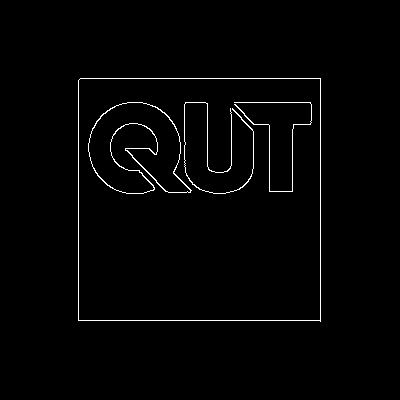

In [11]:
canny_image

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.58it/s]


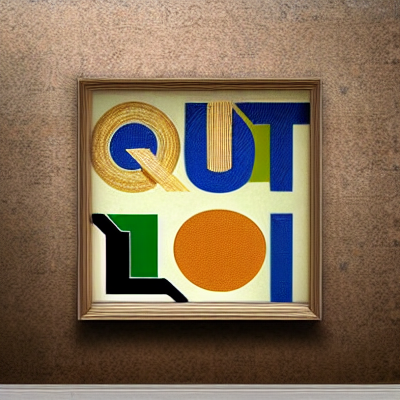

In [12]:
generator = torch.Generator().manual_seed(0)

output = pipe(
    "chess board, van gogh style, muted colours, ", 
    image=canny_image, 
    negative_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality',
    num_inference_steps = 100, 
    generator = generator,
).images[0]
output